In [1]:
import torch
import gc
import os
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


os.chdir("./advanced-DL-project")

from mimo_eval import eval
#from resnet18_10 import mimo_wide_resnet18
#from resnet18_10_deter import wide_resnet18

%load_ext autoreload
%autoreload 2


gc.collect()
torch.cuda.empty_cache()

In [2]:
smallcnn = torch.load("/home/rebwarbajallan/smallcnn.pt")

In [3]:
smallcnn.running_stats[0]["Testing Accuracies"]

[31.979999999999997, 31.1, 31.75]

In [3]:
# (epochs, ensemble, weights)

nr_samples = 10000
nr_clases = 10
nr_ensembles = smallcnn.ensemble_size

run_stats = smallcnn.running_stats
epochs = len(run_stats)

#epoch_ens_acc = np.zeros(shape=(epochs, nr_ensembles, 1))
weight_changes = np.zeros(shape=(epochs, nr_ensembles, 2))

for epoch in run_stats:
    accuracies = run_stats[epoch]["Testing Accuracies"]
    weight_deltas = run_stats[epoch]["Training weight delta"]
    #print(weight_deltas)
    for ens in range(nr_ensembles):
        weight_changes[epoch, ens, 0] = weight_changes[epoch-1, ens, 0] + weight_deltas[ens]["w1"] 
        weight_changes[epoch, ens, 1] = weight_changes[epoch-1, ens, 1] + weight_deltas[ens]["w2"]
        #epoch_ens_acc[epoch, ens, 0] =  accuracies[ens]

#weight_changes = weight_changes.reshape(nr_ensembles, epochs, 2)
print("Shape: ", weight_changes.shape)
#print("Shape: ", epoch_ens_acc.shape)

Shape:  (40, 3, 2)


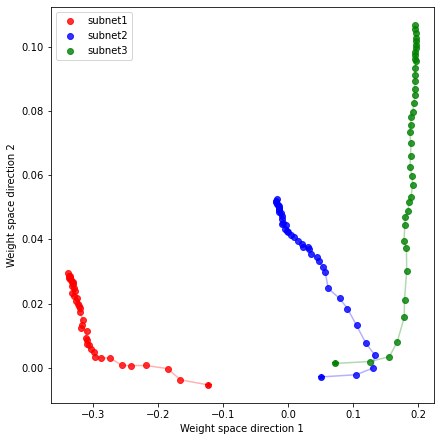

In [21]:
import seaborn as sns

plt.figure(constrained_layout=True, figsize=(6,6))
plt.xlabel("Weight space direction 1")
plt.ylabel("Weight space direction 2")


colors_list=['r', 'b', 'g']
labels=["subnet1", "subnet2", "subnet3"]

for i in range(nr_ensembles):
  plt.plot(weight_changes[:,i,0], weight_changes[:,i,1], color = colors_list[i], alpha=0.8, linestyle = "", marker = "o", label=labels[i])
  plt.plot(weight_changes[:,i,0], weight_changes[:,i,1], color = colors_list[i], alpha=0.3, linestyle = "-", marker = "")
  plt.plot(weight_changes[0,i,0], weight_changes[0,i,1], color = colors_list[i], alpha=1.0, linestyle = "", marker = "*")

plt.legend()


In [5]:
import numpy as np

nr_samples = 10000
nr_clases = 10
nr_ensembles = smallcnn.ensemble_size

run_stats = smallcnn.running_stats

test_probs = []
epochs = len(run_stats)
for epoch in run_stats:
    probs = torch.cat(run_stats[epoch]["Testing class-predictions"], dim=1)
    # print("Probs shape: ", probs.size())
    test_probs.append(probs)
    
probabilities = torch.stack(test_probs).cpu().numpy()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


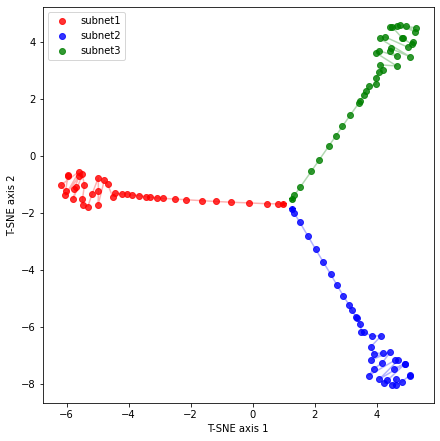

In [20]:
tsne = TSNE(n_components=2)

probabilities = probabilities.reshape([-1, nr_samples*nr_clases])
tsne_trajectories = tsne.fit_transform(probabilities)
tsne_trajectories= tsne_trajectories.reshape([-1, nr_ensembles, 2])


colors_list=['r', 'b', 'g']
labels=["subnet1", "subnet2", "subnet3"]

plt.figure(constrained_layout=True, figsize=(6,6))
plt.xlabel("T-SNE axis 1")
plt.ylabel("T-SNE axis 2")

for i in range(nr_ensembles):
  plt.plot(tsne_trajectories[:,i,0], tsne_trajectories[:,i,1], color=colors_list[i], alpha = 0.8,linestyle = "", marker = "o", label=labels[i])
  plt.plot(tsne_trajectories[:,i,0], tsne_trajectories[:,i,1], color=colors_list[i], alpha = 0.3,linestyle = "-", marker = "")
  plt.plot(tsne_trajectories[0,i,0], tsne_trajectories[0,i,1], color=colors_list[i], alpha = 1.0,linestyle = "", marker = "*")

plt.legend()


In [ ]:
cifar10_mean = (0.4914, 0.4822, 0.4465) 
cifar10_std = (0.2470, 0.2435, 0.2616)

# Image preprocessing modules
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(cifar10_mean, cifar10_std)])

batch_size = 256

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
                                       
testloader = torch.utils.data.DataLoader(
                                    testset, 
                                    batch_size=batch_size,
                                    shuffle=False,
                                    pin_memory=True,
                                )

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
from mimo_eval import eval

(
    accuracy, 
    running_loss, 
    running_ece, 
    member_accuracies,
    member_losses, 
    member_logits,
    pairwise_disagreement, pairwise_kl_diversity
) = eval(smallcnn, testloader)

In [ ]:
pairwise_disagreement

In [ ]:
import gc
  
gc.collect()
torch.cuda.empty_cache()